In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-04
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [7]:
from pytorch_metric_learning.losses import ContrastiveLoss
criteria = ContrastiveLoss()
optimizer = torch.optim.Adam(resnet1.parameters(), lr=learning_rate)
model_name = 'contrast-aug.pth'

Epoch: 1/5, Train Loss: 1.0089165150459403,  Validation Loss: 1.032126206618089
Validation Loss Decreased(inf ---> 1.032126206618089)
Epoch: 2/5, Train Loss: 1.0058821393554942,  Validation Loss: 1.046208422917586
Epoch: 3/5, Train Loss: 1.004900832457736,  Validation Loss: 1.0356595516204834
Epoch: 4/5, Train Loss: 1.0037781556593977,  Validation Loss: 1.0797595427586482
Epoch: 5/5, Train Loss: 1.00092295900922,  Validation Loss: 1.1341925309254572


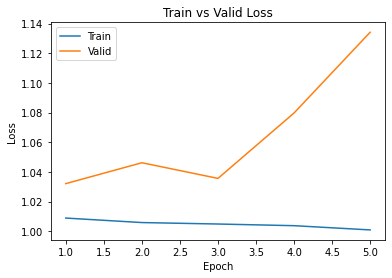

In [8]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [9]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 29.03972053527832
Minimum: 0.0, Maximum: 90.0, Median: 29.0
Mean Absolute Error: 29.48236656188965
Minimum: 0.0, Maximum: 93.0, Median: 30.0


In [10]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 84.00
2  No Sample
3 : 2 : 51.00
4 : 1 : 76.00
5 : 1 : 31.00
6 : 2 : 30.50
7 : 2 : 41.00
8 : 2 : 32.00
9 : 1 : 27.00
10 : 3 : 50.33
11 : 4 : 31.00
12 : 3 : 48.00
13 : 4 : 39.00
14 : 5 : 30.00
15 : 9 : 36.00
16 : 10 : 41.70
17 : 16 : 36.88
18 : 24 : 39.50
19 : 22 : 40.64
20 : 32 : 36.22
21 : 33 : 34.76
22 : 37 : 31.11
23 : 42 : 32.48
24 : 52 : 34.88
25 : 57 : 31.28
26 : 55 : 29.56
27 : 61 : 31.90
28 : 69 : 31.93
29 : 62 : 29.21
30 : 77 : 30.55
31 : 63 : 29.48
32 : 75 : 29.72
33 : 67 : 30.03
34 : 72 : 31.15
35 : 82 : 26.83
36 : 69 : 28.94
37 : 74 : 27.49
38 : 76 : 29.09
39 : 64 : 27.14
40 : 77 : 28.13
41 : 64 : 28.73
42 : 71 : 30.92
43 : 65 : 28.55
44 : 56 : 29.91
45 : 68 : 28.50
46 : 57 : 25.35
47 : 58 : 23.52
48 : 62 : 27.05
49 : 53 : 25.11
50 : 63 : 24.57
51 : 57 : 21.42
52 : 62 : 23.89
53 : 50 : 26.92
54 : 51 : 24.75
55 : 59 : 21.42
56 : 45 : 24.00
57 : 49 : 22.18
58 : 49 : 22.47
59 : 43 : 23.28
60 : 49 : 25.88
61 : 41 : 22.68
62 : 48 : 20.35
63 : 

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/5, Train Loss: 1.012089776468801,  Validation Loss: 1.003298268868373
Validation Loss Decreased(inf ---> 1.003298268868373)
Epoch: 2/5, Train Loss: 1.006551029917958,  Validation Loss: 1.0266311168670654
Epoch: 3/5, Train Loss: 1.0030446746847133,  Validation Loss: 1.0154147102282598
Epoch: 4/5, Train Loss: 0.9963049017466031,  Validation Loss: 1.064068262393658
Epoch: 5/5, Train Loss: 1.0063538957428146,  Validation Loss: 1.0702399015426636


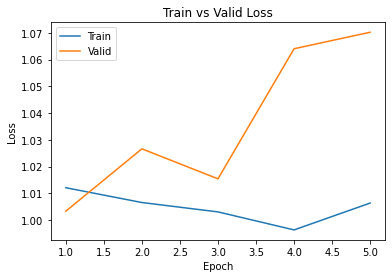

In [11]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = ContrastiveLoss()
optimizer = torch.optim.Adam(resnet2.parameters(), lr=learning_rate)
model_name = 'contrast.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [12]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 26.379623413085938
Minimum: 0.0, Maximum: 91.0, Median: 22.0
Mean Absolute Error: 25.92790985107422
Minimum: 0.0, Maximum: 92.0, Median: 21.0


In [13]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 31.00
2  No Sample
3 : 2 : 29.50
4 : 1 : 78.00
5 : 1 : 10.00
6 : 2 : 26.50
7 : 2 : 82.50
8 : 2 : 27.00
9 : 1 : 84.00
10 : 3 : 13.33
11 : 4 : 11.50
12 : 3 : 72.33
13 : 4 : 46.50
14 : 5 : 30.20
15 : 9 : 42.89
16 : 10 : 36.60
17 : 16 : 14.12
18 : 24 : 20.96
19 : 22 : 25.45
20 : 32 : 32.00
21 : 33 : 22.73
22 : 37 : 24.05
23 : 42 : 33.52
24 : 52 : 30.58
25 : 57 : 28.32
26 : 55 : 29.60
27 : 61 : 31.48
28 : 69 : 29.25
29 : 62 : 29.13
30 : 77 : 27.95
31 : 63 : 32.03
32 : 75 : 28.97
33 : 67 : 29.40
34 : 72 : 30.01
35 : 82 : 26.80
36 : 69 : 27.61
37 : 74 : 24.61
38 : 76 : 24.70
39 : 64 : 25.02
40 : 77 : 26.17
41 : 64 : 26.84
42 : 71 : 24.87
43 : 65 : 26.95
44 : 56 : 26.12
45 : 68 : 22.97
46 : 57 : 29.12
47 : 58 : 23.76
48 : 62 : 21.85
49 : 53 : 21.23
50 : 63 : 24.70
51 : 57 : 22.68
52 : 62 : 22.55
53 : 50 : 21.76
54 : 51 : 22.25
55 : 59 : 23.32
56 : 45 : 21.42
57 : 49 : 23.22
58 : 49 : 24.94
59 : 43 : 24.09
60 : 49 : 22.51
61 : 41 : 24.56
62 : 48 : 22.04
63 : 